your_project/
├── audio_files/
│   ├── 001.wav
│   ├── 002.wav
│   └── ...
└── transcript_files/
    ├── transcripts.csv

In [8]:
import os
import sys
import subprocess
import shutil
import json
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import textgrid # Used for TextGrid manipulation

# New dependencies for pure Python audio processing
import soundfile as sf
from scipy import signal
import webrtcvad

# --- Configuration ---
# Set up your input directories here
AUDIO_INPUT_DIR = "./audio" # Folder containing original audio files (e.g., 001.wav, 002.mp3)
TRANSCIPT_INPUT_DIR = "./transcripts" # Folder containing transcript files (e.g., 001.csv, 002.txt)

# Set up output and temporary directories
NORMALIZED_DIR = "./normalized_audio" # Will contain normalized audio files (16kHz mono WAV)
TRIMMED_DIR = "./trimmed_audio" # Will contain trimmed audio (just speech sections) and corresponding text files
OUTPUT_DIR = "./aligned_output" # For alignment results (TextGrids and CSVs)
TEMP_DIR = "./textgrid" # For temporary MFA files and ffmpeg outputs
METADATA_DIR = "./metadata" # For timing metadata generated during audio processing

# --- Create directories if they don't exist ---
os.makedirs(NORMALIZED_DIR, exist_ok=True)
os.makedirs(TRIMMED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(METADATA_DIR, exist_ok=True)

print("Directories created/ensured:")
print(f" - Normalized Audio: {NORMALIZED_DIR}")
print(f" - Trimmed Audio & Texts: {TRIMMED_DIR}")
print(f" - Aligned Output: {OUTPUT_DIR}")
print(f" - Temporary Files: {TEMP_DIR}")
print(f" - Metadata: {METADATA_DIR}")

Directories created/ensured:
 - Normalized Audio: ./normalized_audio
 - Trimmed Audio & Texts: ./trimmed_audio
 - Aligned Output: ./aligned_output
 - Temporary Files: ./textgrid
 - Metadata: ./metadata


# Checking out the wav files we have


In [9]:
# audio playback in notebook
from IPython.display import Audio, display

# play wav file in folder
def play_audio(file_path):
    display(Audio(filename=file_path))

play_audio("./audio/audio1_1_english.wav")  # Change to your audio file path


This section defines all the helper functions required for the pipeline. You generally don't need to modify these unless you want to customize the audio processing or alignment logic.

In [10]:
def normalize_audio_pure_python(input_file, output_file):
    """
    Convert audio to 16kHz mono 16-bit WAV format, apply highpass/lowpass filters,
    and normalize loudness.
    """
    print(f"Normalizing (Pure Python): {os.path.basename(input_file)}")
    try:
        data, samplerate = sf.read(str(input_file), dtype='float32') # Added str() for robustness

        # Convert to mono if stereo
        if data.ndim > 1:
            data = np.mean(data, axis=1)

        target_samplerate = 16000

        # Resample to 16kHz
        if samplerate != target_samplerate:
            num = int(data.shape[0] * target_samplerate / samplerate)
            data = signal.resample(data, num)
            samplerate = target_samplerate

        # --- LOUDNESS ADJUSTMENT START ---
        # Normalize to a peak of 0.95 (before converting to int16)
        # This will boost quieter audio without clipping if its original peak is low.
        # If the audio is already loud, data.max() will be close to 1.0, and it won't change much.
        peak_amplitude = np.max(np.abs(data))
        if peak_amplitude > 0: # Avoid division by zero for silent audio
            target_peak = 0.95 # Aim for 95% of the maximum possible amplitude
            data = data * (target_peak / peak_amplitude)
        # --- LOUDNESS ADJUSTMENT END ---

        # Ensure data is within valid float range before scaling to int16
        data = np.clip(data, -1.0, 1.0) # Clip to avoid overflow after filtering

        # Scale to 16-bit PCM range (-32768 to 32767)
        data_int16 = (data * 32767).astype(np.int16)

        sf.write(str(output_file), data_int16, samplerate) # Added str() for robustness
        print("Audio normalization succeeded.")
        return True
    except Exception as e:
        print(f"Error normalizing audio with pure Python: {e}")
        return False

def detect_speech_regions_webrtcvad(audio_file, vad_aggressiveness=1):
    """
    Detect speech regions in audio file using WebRTC VAD.
    Returns a list of (start_time, end_time) tuples for speech regions.
    Assumes 16kHz mono 16-bit WAV input.
    """
    print(f"Detecting speech (WebRTC VAD): {os.path.basename(audio_file)}")

    vad = webrtcvad.Vad(vad_aggressiveness) # Aggressiveness 0-3 (0 least aggressive, 3 most aggressive)

    try:
        # Read raw 16-bit PCM data (assuming normalized_audio_pure_python already produced this)
        data, samplerate = sf.read(audio_file, dtype='int16')

        if samplerate not in [8000, 16000, 32000] or data.ndim > 1:
            print(f"Warning: Audio for VAD is not in WebRTC VAD compatible format (16kHz mono 16-bit). Attempting to convert.")
            # If for some reason the audio wasn't 16kHz mono 16-bit, re-process
            # This shouldn't be strictly necessary if normalize_audio_pure_python works correctly.
            if data.ndim > 1:
                data = np.mean(data, axis=1).astype(np.int16) # Convert to mono
            if samplerate != 16000:
                num = int(data.shape[0] * 16000 / samplerate)
                data = signal.resample(data, num).astype(np.int16)
                samplerate = 16000
            
        raw_audio = data.tobytes() # Convert numpy array to bytes
    except Exception as e:
        print(f"Error loading audio for VAD: {e}")
        return []

    frame_duration_ms = 30  # WebRTC VAD operates on 10, 20, or 30 ms frames
    bytes_per_frame = int(samplerate * (frame_duration_ms / 1000.0) * 2) # 2 bytes per sample for int16

    speech_regions = []
    current_speech_start = -1
    
    # Iterate over frames and check for speech
    for i in range(0, len(raw_audio) - bytes_per_frame + 1, bytes_per_frame):
        frame = raw_audio[i:i + bytes_per_frame]
        is_speech = vad.is_speech(frame, samplerate)
        
        current_time_seconds = i / (samplerate * 2.0) # Time in seconds (2 bytes/sample)
        
        if is_speech:
            if current_speech_start == -1: # Start of a new speech segment
                current_speech_start = current_time_seconds
        else: # Not speech
            if current_speech_start != -1: # End of a speech segment
                speech_regions.append((current_speech_start, current_time_seconds))
                current_speech_start = -1 # Reset for next segment

    # Add the last speech segment if the audio ends with speech
    if current_speech_start != -1:
        speech_regions.append((current_speech_start, len(raw_audio) / (samplerate * 2.0)))

    # Merge closely spaced speech regions (similar to previous logic)
    merged_regions = []
    if speech_regions:
        current_start, current_end = speech_regions[0]
        for i in range(1, len(speech_regions)):
            next_start, next_end = speech_regions[i]
            # Merge if gap is less than 0.2 seconds
            if next_start - current_end < 0.2:
                current_end = max(current_end, next_end)
            else:
                merged_regions.append((current_start, current_end))
                current_start, current_end = next_start, next_end
        merged_regions.append((current_start, current_end))
    speech_regions = merged_regions

    # Filter out very short speech segments (e.g., less than 0.5 seconds)
    speech_regions = [(s, e) for s, e in speech_regions if (e - s) > 0.5]

    if speech_regions:
        print(f"Detected {len(speech_regions)} speech regions:")
        for i, (start, end) in enumerate(speech_regions):
            print(f"  Region {i+1}: {start:.2f}s - {end:.2f}s (duration: {end-start:.2f}s)")
    else:
        # Fallback to full duration if no speech detected
        try:
            full_duration_seconds = len(raw_audio) / (samplerate * 2.0) # 2 bytes/sample for int16
            print(f"No significant speech regions detected. Defaulting to full audio duration: {full_duration_seconds:.2f}s.")
            speech_regions = [(0.0, full_duration_seconds)]
        except Exception: # If audio loading itself failed
             print("Could not determine full audio duration for fallback. Returning empty list.")
             speech_regions = []

    return speech_regions

def find_main_speech_region(speech_regions, duration_of_full_audio):
    """
    Find the most significant speech region (longest duration).
    If no significant speech, defaults to the full audio duration.
    """
    if not speech_regions:
        print("No speech regions provided. Defaulting to full audio duration.")
        return (0.0, duration_of_full_audio) # Return full duration if no regions

    longest_region = max(speech_regions, key=lambda x: x[1] - x[0])
    return longest_region

def trim_audio_pure_python(input_file, output_file, start_time, end_time):
    """Trim audio file to extract just the speech section using soundfile."""
    duration = end_time - start_time

    if duration <= 0:
        print(f"Warning: Calculated trim duration is non-positive ({duration:.2f}s). Skipping trim and copying input to output.")
        try:
            shutil.copy(input_file, output_file)
            return True
        except Exception as e:
            print(f"Error copying file: {e}")
            return False

    try:
        data, samplerate = sf.read(input_file, dtype='int16') # Read as int16 as it's normalized WAV
        
        start_sample = int(start_time * samplerate)
        end_sample = int(end_time * samplerate)

        trimmed_data = data[start_sample:end_sample]
        
        sf.write(output_file, trimmed_data, samplerate)
        print(f"Trimmed audio to speech section (Pure Python): {start_time:.2f}s - {end_time:.2f}s (duration: {duration:.2f}s)")
        return True
    except Exception as e:
        print(f"Error trimming audio with pure Python: {e}")
        print(f"Attempting to copy full normalized audio as trimmed: {input_file} -> {output_file}")
        try:
            shutil.copy(input_file, output_file)
            return True # Consider it successful if fallback copy works
        except Exception as e_copy:
            print(f"Error copying file after trim failure: {e_copy}")
            return False

In [11]:

# Initial creation of OUTPUT_DIR_NAME (it's meant to persist)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def perform_full_forced_alignment(audio_file_paths: list[str], 
                                  transcripts: list[str],
                                  mfa_model_name: str = "dutch_cv") -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs the entire forced alignment pipeline on provided audio files and transcript data.
    The order of audio_file_paths must correspond to the order of transcripts.

    This function coordinates:
    1. Per-audio processing (normalization, speech detection, trimming) using Soundfile/SciPy/WebRTC VAD.
    2. Creation of individual transcript text files.
    3. Execution of the Montreal Forced Aligner (MFA).
    4. Post-processing of MFA TextGrids to adjust timings to original audio context.
    5. Export of word and phone alignments to CSV files.
    6. Cleanup of all temporary and intermediate directories.

    Args:
        audio_file_paths (list[str]): A list of full paths to the input audio files (e.g., WAV, MP3).
        transcripts (list[str]): A list of transcript strings, where the Nth transcript
                                 corresponds to the Nth audio file in `audio_file_paths`.
        mfa_model_name (str): The name of the MFA acoustic model and dictionary to use
                              (e.g., "english", "dutch_cv"). Defaults to "dutch_cv".

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames:
                                           (word_alignments_df, phone_alignments_df).
                                           Returns (None, None) if no successful alignments occurred.
    """
    print("\n" + "="*50)
    print("=== STARTING FULL FORCED ALIGNMENT PROCESS ===")
    print("="*50)

    if len(audio_file_paths) != len(transcripts):
        print("Error: The number of audio file paths must match the number of transcripts.")
        return None, None
    
    if not audio_file_paths:
        print("No audio files provided. Aborting alignment.")
        return None, None

    # Define actual paths for this run's working directories
    normalized_dir_path = Path(NORMALIZED_DIR)
    trimmed_dir_path = Path(TRIMMED_DIR)
    metadata_dir_path = Path(METADATA_DIR)
    temp_dir_path = Path(TEMP_DIR) # This is the critical one

    # --- Clean up and Recreate temporary directories for THIS run ---
    print("\n--- Cleaning up previous run's temporary directories ---")
    #shutil.rmtree(normalized_dir_path, ignore_errors=True)
    #shutil.rmtree(trimmed_dir_path, ignore_errors=True)
    #shutil.rmtree(metadata_dir_path, ignore_errors=True)
    #shutil.rmtree(temp_dir_path, ignore_errors=True) # Clears 'temp' and everything inside it

    # Recreate them for the current run
    print("--- Creating temporary directories for current run ---")
    os.makedirs(normalized_dir_path, exist_ok=True)
    os.makedirs(trimmed_dir_path, exist_ok=True)
    os.makedirs(metadata_dir_path, exist_ok=True)
    os.makedirs(temp_dir_path, exist_ok=True) # Recreates 'temp'

    # MFA's raw TextGrid output sub-directory (now guaranteed to have its parent 'temp' existing)
    mfa_raw_output_dir = temp_dir_path / "mfa_raw_output"
    mfa_raw_output_dir.mkdir(exist_ok=True) # This should now succeed
    
    # --- Initialize containers for results and metadata ---
    processed_file_metadata = {} # Stores paths and time_offsets for each file
    
    # MFA's raw TextGrid output goes here temporarily
    mfa_raw_output_dir = Path(TEMP_DIR) / "mfa_raw_output"
    mfa_raw_output_dir.mkdir(exist_ok=True)

    # --- 1. Process Each Audio File & Prepare Transcripts for MFA ---
    print("\n--- Processing Audio Files & Preparing Transcripts for MFA ---")
    processed_audio_count = 0

    # Combine and sort based on audio file names to ensure consistent processing and association
    # We create pairs (audio_path, transcript) and then sort by audio_path base name
    # This ensures deterministic processing order regardless of input list order,
    # and keeps audio path/transcript pairs together.
    combined_inputs = sorted(zip(audio_file_paths, transcripts), key=lambda x: os.path.basename(x[0]))

    for i, (original_audio_path, current_transcript_text) in enumerate(combined_inputs):
        base_name = os.path.splitext(os.path.basename(original_audio_path))[0]
        
        current_transcript_text = str(current_transcript_text).strip()
        if not current_transcript_text:
            print(f"Warning: Empty transcript provided for audio file {base_name}. Skipping.")
            continue

        print(f"\nProcessing '{base_name}' from '{original_audio_path}'...")

        # Define specific paths for this file within the global directories
        norm_wav_path = os.path.join(NORMALIZED_DIR, f"{base_name}.wav")
        trimmed_wav_path = os.path.join(TRIMMED_DIR, f"{base_name}.wav")
        text_file_path = os.path.join(TRIMMED_DIR, f"{base_name}.txt") # MFA expects text file in the same directory as audio

        # 1.1 Normalize audio (using pure Python/SciPy/Soundfile)
        # Call the pure Python normalization function
        if not normalize_audio_pure_python(original_audio_path, norm_wav_path):
            print(f"  Failed to normalize {base_name}, skipping...")
            continue

        # Get normalized audio duration using soundfile
        try:
            info = sf.info(norm_wav_path)
            normalized_audio_duration = info.duration
        except Exception as e:
            normalized_audio_duration = 0.0
            print(f"  Warning: Could not determine duration for normalized audio '{base_name}' using soundfile: {e}.")


        # 1.2 Detect speech regions (using WebRTC VAD)
        # Call the WebRTC VAD based speech detection function
        speech_regions = detect_speech_regions_webrtcvad(norm_wav_path)

        # 1.3 Find main speech region
        main_region = find_main_speech_region(speech_regions, normalized_audio_duration)
        
        # Ensure main_region is valid for trimming, fallback to full audio if not significant
        if main_region[1] - main_region[0] <= 0 and normalized_audio_duration > 0:
            print(f"  No significant speech detected or invalid region for {base_name}. Using full normalized audio for trimming.")
            main_region = (0.0, normalized_audio_duration)
        elif normalized_audio_duration == 0:
             print(f"  Cannot determine audio duration for {base_name}. Skipping trimming and alignment for this file.")
             continue # Cannot proceed without a valid duration
        
        time_offset_seconds = main_region[0] # This is the start of the trimmed segment in the *normalized* audio

        # 1.4 Trim audio (using pure Python/Soundfile)
        # Call the pure Python trimming function
        if not trim_audio_pure_python(norm_wav_path, trimmed_wav_path, main_region[0], main_region[1]):
            print(f"  Failed to trim {base_name}, skipping...")
            continue

        # 1.5 Write transcript text file (in TRIMMED_DIR next to trimmed audio for MFA)
        try:
            with open(text_file_path, 'w', encoding='utf-8') as f:
                f.write(current_transcript_text)
            print(f"  Prepared transcript text for '{base_name}' at '{text_file_path}'.")
        except Exception as e:
            print(f"  Error writing transcript for '{base_name}': {e}. Skipping alignment.")
            continue

        # Store metadata for post-processing MFA results
        processed_file_metadata[base_name] = {
            "trimmed_audio_path": trimmed_wav_path,
            "text_file_path": text_file_path,
            "time_offset_seconds": time_offset_seconds # Offset from start of normalized audio
        }
        processed_audio_count += 1

    if processed_audio_count == 0:
        print("\nNo audio files were successfully prepared for alignment. Aborting pipeline.")
        # Cleanup any partially created directories here
        #shutil.rmtree(NORMALIZED_DIR, ignore_errors=True)
        #shutil.rmtree(TRIMMED_DIR, ignore_errors=True)
        #shutil.rmtree(METADATA_DIR, ignore_errors=True)
        #shutil.rmtree(TEMP_DIR, ignore_errors=True)
        return None, None

    # --- 2. Run MFA Alignment ---
    print("\n--- Running Montreal Forced Aligner ---")
    successful_alignments = {}

    for base_name, info in processed_file_metadata.items():
        trimmed_audio_path = info["trimmed_audio_path"]
        text_file_path = info["text_file_path"]
        mfa_output_tg = mfa_raw_output_dir / f"{base_name}.TextGrid"

        if not os.path.exists(trimmed_audio_path) or not os.path.exists(text_file_path):
            print(f"Skipping MFA for '{base_name}': Required trimmed audio or text file missing.")
            continue

        print(f"\nAligning '{base_name}'...")
        
        # *** ADJUSTMENT HERE: Create command as a list of strings ***
        mfa_cmd_list = [
            'mfa',
            'align_one',
            '--verbose',
            '--cleanup_textgrids',
            str(trimmed_audio_path),  # Ensure it's a string
            str(text_file_path),      # Ensure it's a string
            mfa_model_name,
            mfa_model_name,
            str(mfa_output_tg)        # Ensure it's a string
        ]
        
        print(f"  Executing MFA command (list format): {' '.join(mfa_cmd_list)}") # For debugging

        try:
            # Change shell=True to shell=False, and pass the list directly
            result = subprocess.run(mfa_cmd_list, capture_output=True, text=True, check=True)
            print(f"   ✓ Successfully aligned '{base_name}'.")
            successful_alignments[base_name] = {
                "mfa_textgrid": str(mfa_output_tg),
                "time_offset_seconds": info["time_offset_seconds"]
            }
        except subprocess.CalledProcessError as e:
            print(f"   × Error aligning '{base_name}':\n{e.stderr}")
            print(f"   MFA stdout: {e.stdout}")
        except Exception as e:
            print(f"   × Unexpected error during alignment for '{base_name}': {e}")

    if not successful_alignments:
        print("\nNo files were successfully aligned by MFA. Aborting pipeline.")
        # Cleanup all directories if MFA failed for everything
        #shutil.rmtree(NORMALIZED_DIR, ignore_errors=True)
        #shutil.rmtree(TRIMMED_DIR, ignore_errors=True)
        #shutil.rmtree(METADATA_DIR, ignore_errors=True)
        #shutil.rmtree(TEMP_DIR, ignore_errors=True)
        return None, None

    # --- 3. Adjust TextGrid Timings and Export Results ---
    print("\n--- Adjusting TextGrid Timings and Exporting Results ---")
    all_words_data = []
    all_phones_data = []

    for base_name, align_info in successful_alignments.items():
        mfa_tg_path = align_info["mfa_textgrid"]
        time_offset = align_info["time_offset_seconds"] # Offset from start of original audio

        if not Path(mfa_tg_path).exists():
            print(f"  MFA TextGrid not found for '{base_name}'. Skipping post-processing for this file.")
            continue

        try:
            tg = textgrid.TextGrid.fromFile(mfa_tg_path)

            # Create an adjusted TextGrid that reflects timings in the original audio context
            # MFA's TextGrid times are relative to the *trimmed* audio.
            # We add the time_offset (start of trimmed audio in original) to shift them back.
            adjusted_tg = textgrid.TextGrid(name=tg.name, 
                                            minTime=tg.minTime + time_offset, 
                                            maxTime=tg.maxTime + time_offset)

            for tier in tg.tiers:
                adjusted_tier = textgrid.IntervalTier(name=tier.name,
                                                      minTime=tier.minTime + time_offset,
                                                      maxTime=tier.maxTime + time_offset)
                
                for interval in tier.intervals:
                    original_start = interval.minTime + time_offset
                    original_end = interval.maxTime + time_offset
                    
                    adjusted_interval = textgrid.Interval(
                        minTime=original_start,
                        maxTime=original_end,
                        mark=interval.mark
                    )
                    adjusted_tier.addInterval(adjusted_interval)

                    # Collect data for CSV export
                    if tier.name == "words" and interval.mark.strip():
                        all_words_data.append({
                            "file_id": base_name,
                            "word": interval.mark,
                            "start_time_seconds": original_start,
                            "end_time_seconds": original_end,
                            "duration_seconds": interval.maxTime - interval.minTime # Duration is length of word in trimmed segment
                        })
                    elif tier.name == "phones" and interval.mark.strip() and interval.mark != "sil": # Exclude 'sil' phones
                        all_phones_data.append({
                            "file_id": base_name,
                            "phone": interval.mark,
                            "start_time_seconds": original_start,
                            "end_time_seconds": original_end,
                            "duration_seconds": interval.maxTime - interval.minTime # Duration is length of phone in trimmed segment
                        })
                adjusted_tg.append(adjusted_tier)
            
            # Save the adjusted TextGrid to the final OUTPUT_DIR
            adjusted_tg_output_path = Path(OUTPUT_DIR) / f"{base_name}_aligned.TextGrid"
            adjusted_tg.write(str(adjusted_tg_output_path))
            print(f"  - Created adjusted TextGrid for '{base_name}'.")

        except Exception as e:
            print(f"  Error processing TextGrid for '{base_name}': {e}. Skipping post-processing for this file.")

    # Create DataFrames
    word_alignments_df = pd.DataFrame(all_words_data)
    phone_alignments_df = pd.DataFrame(all_phones_data)

    # Save DataFrames to CSV in the final OUTPUT_DIR
    # curret time and date
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # convert to string
    uniqueID = str(current_time)+mfa_model_name 
    word_csv_path = Path(OUTPUT_DIR) / f"all_word_alignments{uniqueID}.csv"
    phone_csv_path = Path(OUTPUT_DIR) / f"all_phone_alignments{uniqueID}.csv"

    if not word_alignments_df.empty:
        word_alignments_df.to_csv(word_csv_path, index=False)
        print(f"\nSaved word alignments to: {word_csv_path}")
    else:
        print("\nNo word alignments to save.")

    if not phone_alignments_df.empty:
        phone_alignments_df.to_csv(phone_csv_path, index=False)
        print(f"Saved phone alignments to: {phone_csv_path}")
    else:
        print("No phone alignments to save.")

    # --- 4. Cleanup Temporary Files ---
    print(f"\n--- Cleaning up temporary directories ---")
    try:
        # Using ignore_errors=True for robustness in case some directories are already removed or empty
        # shutil.rmtree(NORMALIZED_DIR, ignore_errors=True)
        # shutil.rmtree(TRIMMED_DIR, ignore_errors=True)
        # shutil.rmtree(METADATA_DIR, ignore_errors=True)
        # shutil.rmtree(TEMP_DIR, ignore_errors=True) # This also removes mfa_raw_output_dir inside it
        print("All temporary directories cleaned successfully.")
    except Exception as e:
        print(f"Error cleaning up temporary directories: {e}")

    print("\n" + "="*50)
    print("=== FULL FORCED ALIGNMENT PROCESS COMPLETED ===")
    print("="*50)

    return word_alignments_df, phone_alignments_df

# English Forced Alignment

In [12]:
# Set up your input directories here
AUDIO_INPUT_DIR = "./audio" # Folder containing original audio files (e.g., 001.wav, 002.mp3)
TRANSCIPT_INPUT_DIR = "./transcripts" # Folder containing transcript files (e.g., 001.csv, 002.txt)

import glob
import pandas as pd

audio_files_list = glob.glob(AUDIO_INPUT_DIR + "/*_english.wav")  # Adjust the glob pattern to match your audio files
transcriptfile = glob.glob(TRANSCIPT_INPUT_DIR + "/*_english.csv")  # Adjust the glob pattern to match your transcript files
transcript = pd.read_csv(transcriptfile[0])  # Assuming the first CSV contains
transcriptlist = transcript['transcript'].tolist()  # Adjust the column name as needed


# print both transciptlist and audio_files_list to verify
print("Audio files to process:", audio_files_list)
print("Transcripts for alignment:", transcriptlist)

final_word_alignments, final_phone_alignments = perform_full_forced_alignment(
    audio_file_paths=audio_files_list,
    transcripts=transcriptlist,
    mfa_model_name="english_us_arpa" # Change this
)   


Audio files to process: ['./audio\\audio1_1_english.wav', './audio\\audio1_2_english.wav']
Transcripts for alignment: ["he didn't feel like working", 'she did not find keys in the bag']

=== STARTING FULL FORCED ALIGNMENT PROCESS ===

--- Cleaning up previous run's temporary directories ---
--- Creating temporary directories for current run ---

--- Processing Audio Files & Preparing Transcripts for MFA ---

Processing 'audio1_1_english' from './audio\audio1_1_english.wav'...
Normalizing (Pure Python): audio1_1_english.wav
Audio normalization succeeded.
Detecting speech (WebRTC VAD): audio1_1_english.wav
Detected 1 speech regions:
  Region 1: 0.90s - 2.37s (duration: 1.47s)
Trimmed audio to speech section (Pure Python): 0.90s - 2.37s (duration: 1.47s)
  Prepared transcript text for 'audio1_1_english' at './trimmed_audio\audio1_1_english.txt'.

Processing 'audio1_2_english' from './audio\audio1_2_english.wav'...
Normalizing (Pure Python): audio1_2_english.wav
Audio normalization succeed

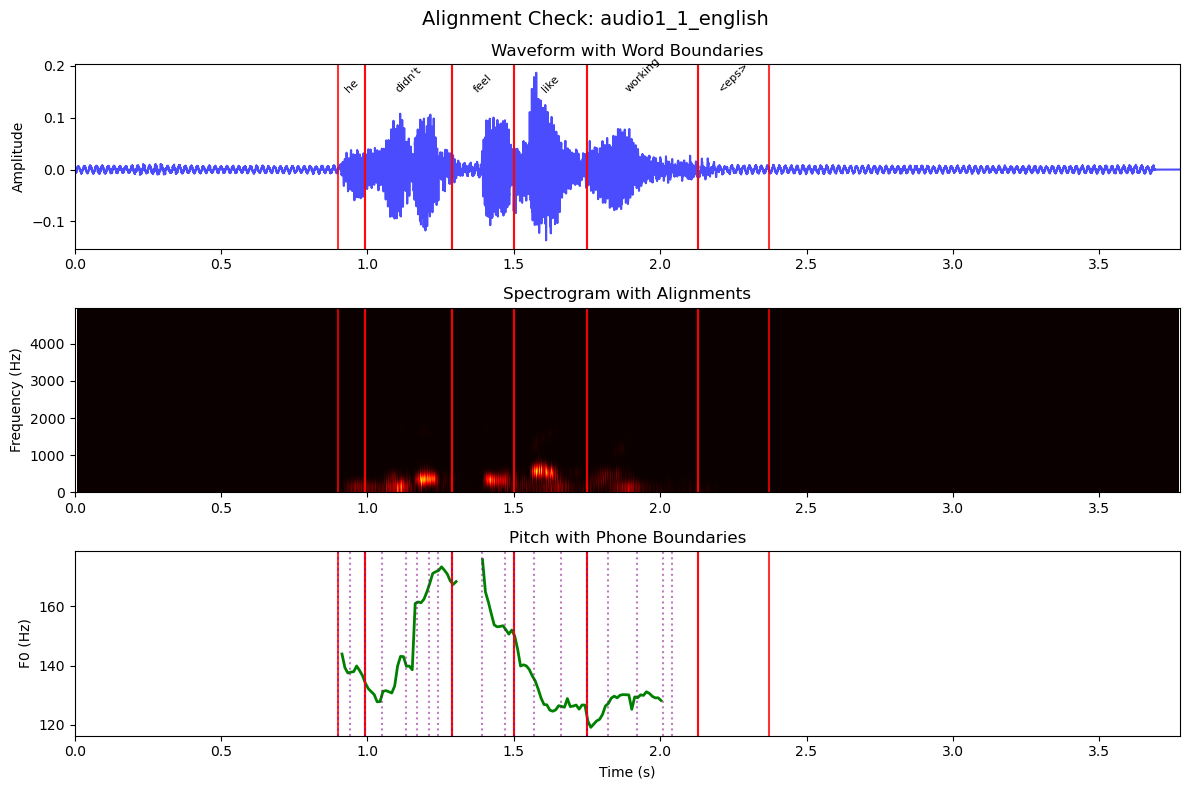


Alignment summary for audio1_1_english:
  Audio duration: 3.78s
  Words aligned: 6
  Phones aligned: 19
  Average phones per word: 3.2
--------------------------------------------------


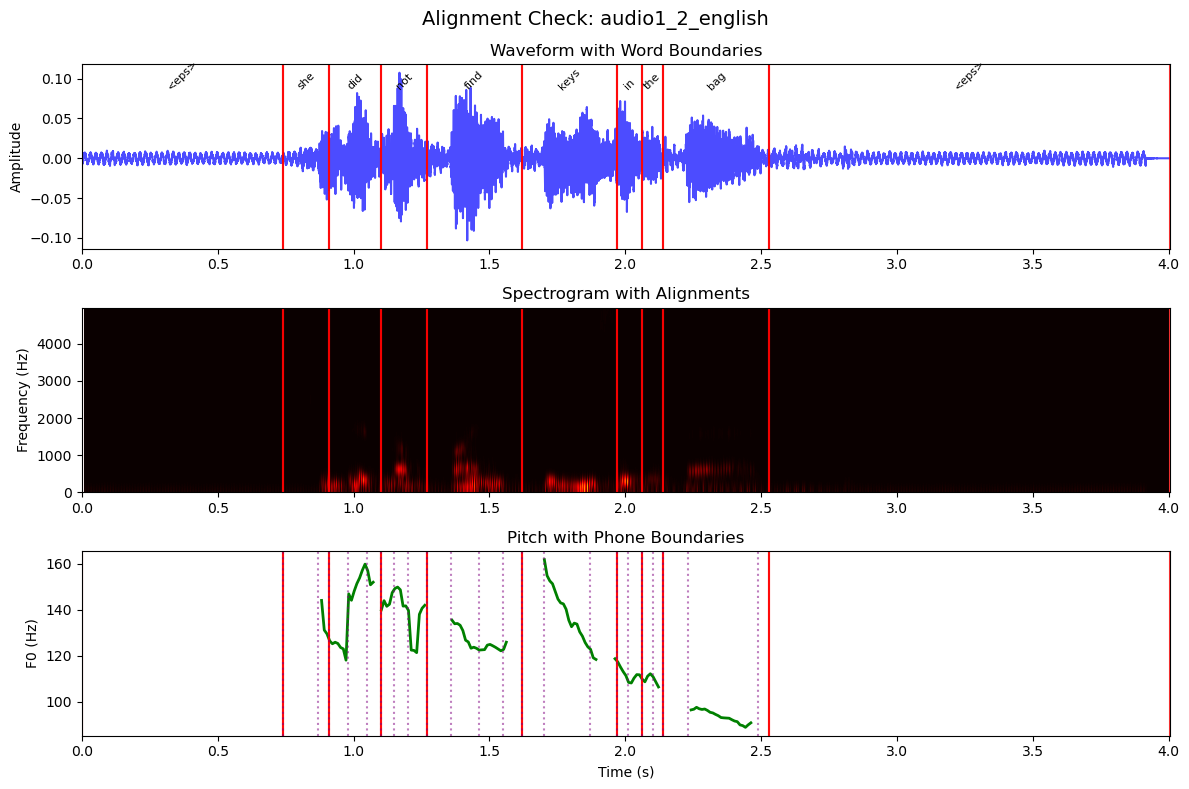


Alignment summary for audio1_2_english:
  Audio duration: 4.00s
  Words aligned: 10
  Phones aligned: 22
  Average phones per word: 2.2
--------------------------------------------------


In [15]:
# Simple alignment visualization using Parslemouth and TextGrid
import glob
import matplotlib.pyplot as plt
import parselmouth
import textgrid
import numpy as np

# Load the most recent TextGrid and corresponding audio
textgrid_files = glob.glob("./aligned_output/*_aligned.TextGrid")
audio_files = glob.glob("./audio/*.wav")

for tg_file in textgrid_files:
    # Extract file ID from TextGrid filename
    file_id = tg_file.split("\\")[-1].replace("_aligned.TextGrid", "")
    
    # Find corresponding audio file
    audio_file = None
    for audio in audio_files:
        if file_id in audio:
            audio_file = audio
            break
    
    if not audio_file:
        print(f"No audio file found for {file_id}")
        continue
    
    # Load audio and TextGrid
    sound = parselmouth.Sound(audio_file)
    tg = textgrid.TextGrid.fromFile(tg_file)
    
    # Create plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f'Alignment Check: {file_id}', fontsize=14)
    
    # Get audio data
    times = sound.xs()
    values = sound.values[0] if sound.values.ndim > 1 else sound.values.flatten()
    
    # Plot waveform
    ax1.plot(times, values, 'b-', alpha=0.7)
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Waveform with Word Boundaries')
    
    # Plot spectrogram
    spectrogram = sound.to_spectrogram()
    spec_times = spectrogram.xs()
    spec_freqs = spectrogram.ys()
    spec_values = spectrogram.values
    
    ax2.imshow(spec_values, aspect='auto', origin='lower',
               extent=[spec_times[0], spec_times[-1], spec_freqs[0], spec_freqs[-1]],
               cmap='hot')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_title('Spectrogram with Alignments')
    
    # Plot pitch
    pitch = sound.to_pitch(pitch_floor=75.0, pitch_ceiling=300.0) # we have Wim's male voice here
    pitch_times = pitch.xs()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values == 0] = np.nan
    
    ax3.plot(pitch_times, pitch_values, 'g-', linewidth=2)
    ax3.set_ylabel('F0 (Hz)')
    ax3.set_xlabel('Time (s)')
    ax3.set_title('Pitch with Phone Boundaries')
    
    # Add word boundaries and labels
    for tier in tg.tiers:
        if tier.name == "words":
            for interval in tier.intervals:
                if interval.mark.strip():
                    start, end = interval.minTime, interval.maxTime
                    word = interval.mark
                    
                    # Add vertical lines
                    for ax in [ax1, ax2, ax3]:
                        ax.axvline(start, color='red', linestyle='-', alpha=0.8)
                        ax.axvline(end, color='red', linestyle='-', alpha=0.8)
                    
                    # Add word labels
                    mid_time = (start + end) / 2
                    ax1.text(mid_time, max(values) * 0.8, word, 
                            rotation=45, fontsize=8, ha='center')
        
        elif tier.name == "phones":
            for interval in tier.intervals:
                if interval.mark.strip() and interval.mark != "sil":
                    start = interval.minTime
                    # Add phone boundaries (lighter lines)
                    ax3.axvline(start, color='purple', linestyle=':', alpha=0.5)
    
    # Set same x-axis limits
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(0, sound.duration)
    
    plt.tight_layout()
    plt.show()
    
    # Print alignment summary
    word_count = sum(1 for tier in tg.tiers if tier.name == "words" 
                     for interval in tier.intervals if interval.mark.strip())
    phone_count = sum(1 for tier in tg.tiers if tier.name == "phones" 
                      for interval in tier.intervals if interval.mark.strip() and interval.mark != "sil")
    
    print(f"\nAlignment summary for {file_id}:")
    print(f"  Audio duration: {sound.duration:.2f}s")
    print(f"  Words aligned: {word_count}")
    print(f"  Phones aligned: {phone_count}")
    print(f"  Average phones per word: {phone_count/word_count:.1f}" if word_count > 0 else "")
    print("-" * 50)